# Origin: voxel center vs corner in ``trackvis``

This notebook demonstrates the voxel corner and center difference with the old and new `NiBabel` API to read `trackvis` files.

We begin downloading the tractogram file.

In [1]:
import os
import requests
from pathlib import Path

output_path = Path(os.getcwd())

url = "https://osf.io/vj2gw/download/"
resp = requests.get(url, allow_redirects=True, stream=True)
sft_fname = output_path / "tractogram_probabilistic_sf.trk"
with open(sft_fname, "wb") as f:
    for chunk in resp.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

Read the tractogram with the old and new `NiBabel` APIs.

In [2]:
import nibabel as nib

# Read with old API
tracts_and_data, header = nib.trackvis.read(sft_fname, points_space="rasmm")
tracts, _, _ = list(zip(*tracts_and_data))
strml_old_api = nib.streamlines.ArraySequence(tracts)

# Read with new API
trk_file = nib.streamlines.load(sft_fname)
strml_new_api = trk_file.streamlines

/tmp/ipykernel_19175/3825779543.py:4: DeprecationWarning: trackvis.read is deprecated; please use nibabel.streamlines.load, instead.

* deprecated from version: 2.5.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0.0
  tracts_and_data, header = nib.trackvis.read(sft_fname, points_space="rasmm")


Define helper functions to plot the tractograms in the three orthogonal axes.

In [3]:
import matplotlib.pyplot as plt
from fury import actor, window

def transform_scene(_view, _scene):
    position = [0, 0, 1]
    focal_point = [0, 0, 0]
    view_up = [0, 1, 0]
    _scene.set_camera(position=position, focal_point=focal_point, view_up=view_up)

    if _view == "axial":
        pass
    elif _view == "coronal":
        _scene.pitch(270)
        _scene.set_camera(view_up=(0, 0, 1))
    elif _view == "sagittal":
        _scene.yaw(-90)
        _scene.roll(90)

def plot_orthogonal_view(_strml_trckvis, _color_strml, _views, _zooms, _background, _size, _figsize, _outdir, ):
    scene_arr = []
    for _view, _zoom in zip(_views, _zooms, strict=True):
        scene = window.Scene()
        scene.background(_background)

        # Add streamlines
        for _strml, _color in zip(_strml_trckvis, _color_strml, strict=True):
            stream_actor = actor.line(_strml, colors=_color)
            scene.add(stream_actor)

        # Set camera for consistent view
        transform_scene(_view, scene)
        scene.reset_camera()
        scene.zoom(_zoom)

        # Render and grab image
        _fname = _outdir / Path(f"corner_vs_center_{_view}.png")
        arr = window.snapshot(scene, fname=_fname, size=_size, offscreen=True)
        scene_arr.append(arr)

    # Plot all three orthogonal views side by side
    _fig, axes = plt.subplots(1, 3, figsize=_figsize)
    for ax, arr, title in zip(axes, scene_arr, _views, strict=True):
        ax.imshow(arr)
        ax.axis("off")
        ax.set_title(title.capitalize())

    plt.tight_layout()
    return _fig

Plot the result and save it.

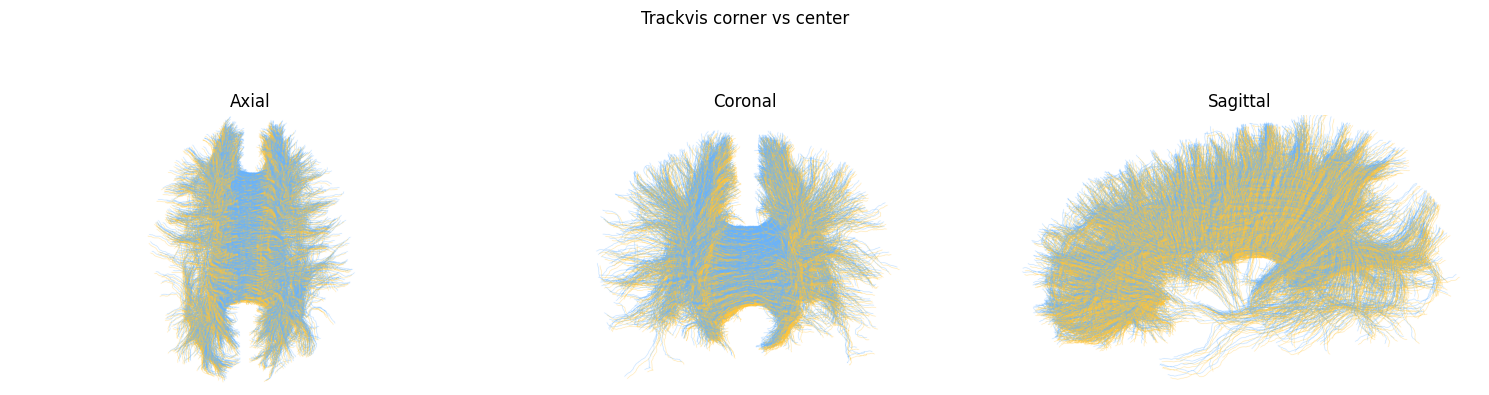

In [4]:
%matplotlib inline
import matplotlib.colors as mcolors

background = window.colors.white
size = (1920, 1080)
figsize = (15, 5)
linewidth = 0.1

color_strml1 = mcolors.hex2color("#66b2ff")
color_strml2 = mcolors.hex2color("#ffc437")

strml_trckvis = [strml_old_api, strml_new_api]
color_strml = [color_strml1, color_strml2]

views = ["axial", "coronal", "sagittal"]
zooms = [1.45, 2.1, 2.25]

fig = plot_orthogonal_view(strml_trckvis, color_strml, views, zooms, background, size, figsize, output_path)
plt.suptitle('Trackvis corner vs center')
plt.show()